# MOE Design Simulation
Simulate an MOE design from a dataset.

In [1]:
# import dependencies
import numpy as np
import json
import os
import sys
import matplotlib.pyplot as plt
from scipy import optimize
import pandas as pd
import random
from IPython.display import Image
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
from concurrent.futures import ProcessPoolExecutor
import threading
import queue
import pathlib
from tff_lib.utils import film_matrix

sys.path.insert(0, r'..\moepy')
import moe, utils, processing, metrics

In [2]:
# set random seed numpy
random.seed(123)

f_path = pathlib.Path(r'..\tests\data\test_uster_plastic_moe\Uster_Plastic-ID_MOE6.xlsx')
f_out = pathlib.Path(r'..\tests\data\test_uster_plastic_moe\out')

# read the excel file
df = processing.excel_to_json(f_path, f_out)

# read in the dataset
## with open(os.path.normpath(r'..\tests\data\test_dow_rev5\out\Dow_MOE_Rev5.json'), 'r') as df:
##     data = json.load(df)

# pre-process the data into numpy arrays
data = processing.convert_to_numpy(df)

Theta range= [0]
Spectral Mean= 0.8280929943639037
Estimated thickness= 5506.191428057048 nanometers


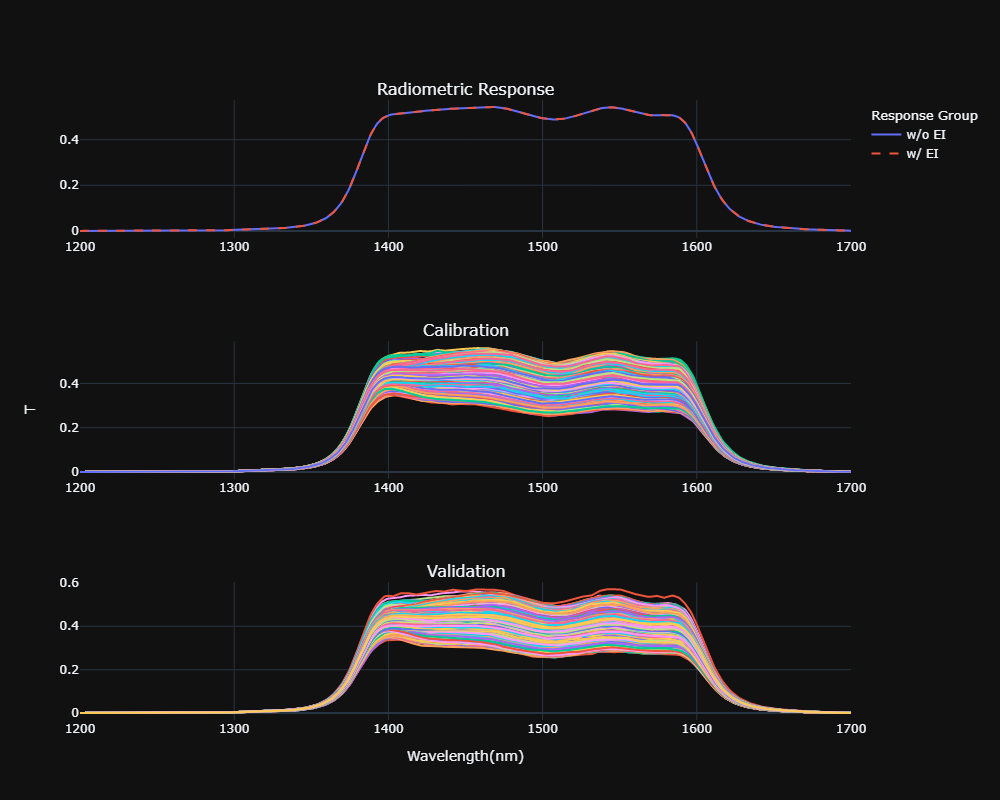

In [3]:
# Compute the range of angles with default N points = 7
angles = utils.theta_range(data['design']['incident_angle'], data['design']['fov'])
print(f'Theta range= {angles}')

# calculate mean of cal/val spectral data
avg, x_cal, x_val = utils.spec_mean(data['calibration']['xcal'], data['validation']['xval'])
print(f'Spectral Mean= {avg}')

# extract optical components from 'setup'
exclude = ('high_material', 'low_material', 'substrate', 'env_int', 'wv')
components = {k: v for k, v in data['setup'].items() if not k in exclude}

# calculate radiometric response
resp, resp_ei = utils.system_response(data['setup']['wv'], components, data['setup']['env_int'])

# normalize the spectral data (axis=0 by default ---> no normalization)
x_cal, x_val = utils.spec_norm(x_cal, x_val)

# convolve the system response with the spectral data
x_cal = data['calibration']['xcal'] * resp_ei
x_val = data['validation']['xval'] * resp_ei

# calculate the estimated total physical thickness
est_thickness = utils.total_thickness(
    data['setup']['high_material'], data['setup']['low_material'], data['design']['spec_res'])
print(f'Estimated thickness= {est_thickness} nanometers')

# plot the spectral data and system response
fig = make_subplots(rows=3, cols=1, subplot_titles=('Radiometric Response', 'Calibration', 'Validation'))
fig.add_trace(go.Scatter(x=data['setup']['wv'], y=resp, name='w/o EI', legendgroup='response', legendgrouptitle_text='Response Group'), row=1, col=1)
fig.add_trace(go.Scatter(x=data['setup']['wv'], y=resp_ei, name='w/ EI', legendgroup='response', line={'dash':'dash'}), row=1, col=1)


for i in range(x_cal.shape[0]):
    fig.add_trace(go.Scatter(x=data['setup']['wv'], y=x_cal[i, :], showlegend=False), row=2, col=1)

for i in range(x_val.shape[0]):
    fig.add_trace(go.Scatter(x=data['setup']['wv'], y=x_val[i, :], showlegend=False), row=3, col=1)

fig.update_xaxes(title_text="Wavelength(nm)", row=3, col=1)
fig.update_yaxes(title_text="T", row=2, col=1)
fig.update_layout(
    template='plotly_dark',
    height=800,
    width=1000
)

# save image to file, then display
fig.write_image('./out/data.png')
Image(filename='./out/data.png')
#fig.show()

In [4]:
def performance_queue(q:queue.Queue):
    """
    """
    while True:
        if not q.empty():
            print(f'Queue: {q.get()}')

# create an iterable for the thread pool executer
inputs = []
for i in range(8):
    inputs.append((
        utils.random_layers(20, est_thickness), angles, data, x_cal, x_val, resp, resp_ei
    ))
outputs = []# queue.Queue()

#threading.Thread(target=performance_queue, args=(outputs, ), daemon=True).start()

# run the simulations with a thread pool executer
with ProcessPoolExecutor(max_workers=8) as ex:
    start_time = time.perf_counter()
    for n, lyrs in ex.map(moe.run_optimizer, inputs):
        print(f'Iters= {n} Layers= {len(lyrs)}')
        outputs.append((n, lyrs))
    end_time = time.perf_counter()
    print(f'Runtime= {(end_time - start_time)/60} minutes.')

Iters= 65 Layers= 3
Iters= 202 Layers= 18
Iters= 250 Layers= 16
Iters= 250 Layers= 14
Iters= 91 Layers= 9
Iters= 175 Layers= 6
Iters= 250 Layers= 13
Iters= 174 Layers= 10
Runtime= 4.069804331666666 minutes.


In [5]:

results = []
# calculate the performance for each result
for out in outputs:
        materials = ["H" if i % 2 == 0 else "L" for i in range(len(out[1]))]
        stack = [(m, l) for m, l in zip(materials, out[1])]
        films = film_matrix(stack, data['setup']['high_material'], data['setup']['low_material'])
        inc_med = np.ones(np.shape(data['setup']['wv']))

        perf = moe.performance(data['setup']['wv'],
                out[1], films, data['setup']['substrate'], inc_med, angles, resp, resp_ei,
                data['design']['sub_thick'], x_cal, data['calibration']['ycal'],
                x_val, data['validation']['yval'], data['design']['opt_comp'])

        results.append((perf['SEC'][0], perf['SEP'][0], perf['SNR'][0], perf['fil_spec']['T'], len(out[1]), out[0], out[1].flatten().tolist()))

# Write results to csv file, without transmission spectrum
with open('./out/results.csv', 'w') as outfile:
    outfile.write('SEC, SEP, SNR, Iters, Layers')
    for i in range(20):
        outfile.write(f", Layer_{i + 1}")
    outfile.write('\n')
    for r in results:
        row = [r[0], r[1], r[2], r[5], r[4]]
        for l in r[6]:
            row.append(l)
        outfile.write(f"{', '.join([str(x) for x in row])}\n")

# read csv as dataframe
df = pd.read_csv('./out/results.csv')

# print the results without showing layer stacks
df.iloc[:, :5]


,SEC,SEP,SNR,Iters,Layers
0,0.322812,0.322276,63625.384713,65,3
1,0.376609,0.374679,3623.584772,202,18
2,0.264928,0.263829,40057.894773,250,16
3,0.274620,0.273174,18003.537928,250,14
4,0.277447,0.275284,15024.742796,91,9
5,0.277885,0.276356,33696.627315,175,6
6,0.267417,0.266178,54147.442763,250,13
7,0.463251,0.463131,1385.767470,174,10


Test: Layers= 14  Total Thick= 6057.8  SEC= 0.43  SEP= 0.43  SNR= 544.28
Sim: Layers= 16  Total Thick= 6324.3  SEC= 0.26  SEP= 0.26  SNR= 40057.89  Iters= 250
Optimizations:
[0] 14.62 -----> 57.96  (+296.58 %)
[1] 627.12 -----> 684.75  (+9.19 %)
[2] 394.66 -----> 394.89  (+0.06 %)
[3] 182.61 -----> 199.17  (+9.06 %)
[4] 576.66 -----> 635.15  (+10.14 %)
[5] 529.14 -----> 534.1  (+0.94 %)
[6] 236.4 -----> 290.74  (+22.99 %)
[7] 551.65 -----> 485.43  (-12.0 %)
[8] 142.38 -----> 103.18  (-27.53 %)
[9] 419.09 -----> 383.45  (-8.5 %)
[10] 362.77 -----> 458.1  (+26.28 %)
[11] 557.05 -----> 691.89  (+24.21 %)
[12] 216.99 -----> 191.05  (-11.95 %)
[13] 274.1 -----> 266.34  (-2.83 %)
[14] 529.47 -----> 583.1  (+10.13 %)
[15] 352.91 -----> 364.98  (+3.42 %)


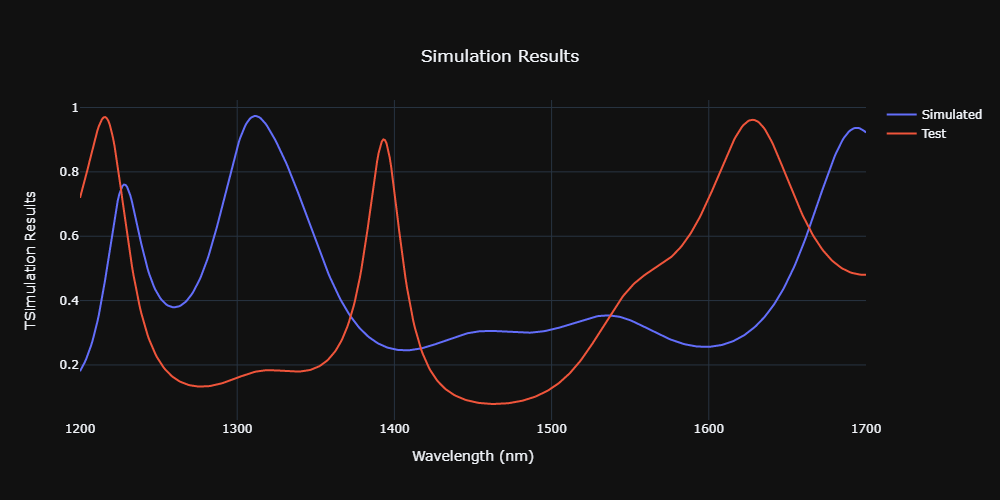

In [6]:
# use min(results) to show the lowest SEC
# use results[index] to plot a specific result
best = min(results)

test_layers = [478.2,343.6,496.4,739.4,456.7,186.8,660.7,558.4,254.9,208.6,466.2,644.9,166.2,396.8]
test_materials = ["H" if i % 2 == 0 else "L" for i in range(len(test_layers))]
test_stack = [(m, l) for m, l in zip(test_materials, test_layers)]
test_films = film_matrix(test_stack, data['setup']['high_material'], data['setup']['low_material'])

test_perf = moe.performance(data['setup']['wv'],
        test_layers, test_films, data['setup']['substrate'], inc_med, angles, resp, resp_ei,
        data['design']['sub_thick'], x_cal, data['calibration']['ycal'],
        x_val, data['validation']['yval'], data['design']['opt_comp'])

# calculate total thicknesses
test_total_thick = np.sum(test_layers)
sim_total_thick = np.sum(best[6])

print(f'Test: Layers= {len(test_layers)}  Total Thick= {round(test_total_thick, 2)}  SEC= {round(test_perf["SEC"][0], 2)}  SEP= {round(test_perf["SEP"][0], 2)}  SNR= {round(test_perf["SNR"][0], 2)}')
print(f'Sim: Layers= {best[4]}  Total Thick= {round(sim_total_thick, 2)}  SEC= {round(best[0], 2)}  SEP= {round(best[1], 2)}  SNR= {round(best[2], 2)}  Iters= {best[5]}')
start_stack = inputs[results.index(best)][0]
print('Optimizations:')
for j, ss in enumerate(start_stack):
        # calculate layer difference
        diff = round((abs(ss[1] - best[6][j])/ss[1]*100), 2)
        if ss[1] < best[6][j]:
                sign = '+'
        else:
                sign = '-'
        print(f'[{j}] {round(ss[1], 2)} -----> {round(best[6][j], 2)}  ({sign}{diff} %)')

# plot the best performance and the test sample
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['setup']['wv'], y=best[3], name='Simulated'))
fig.add_trace(go.Scatter(x=data['setup']['wv'], y=test_perf['fil_spec']['T'], name='Test'))
fig.update_layout(
        template='plotly_dark',
        height=500,
        width=1000,
        title={'text':'Simulation Results', 'y':0.9, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
        xaxis_title="Wavelength (nm)",
        yaxis_title="T"
        'Simulation Results')

# save image to file, then display
fig.write_image('./out/results.png')
Image('./out/results.png')
#fig.show()